<a href="https://colab.research.google.com/github/NoCommentsSir/NLP_classification/blob/main/NLP_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Решаем задачу NLP: классификация текстов**
Данные будем брать с сайта Консультант Плюс, будем разделять новости на сферы деятельности: бухгалтерия, закупки, здравохранение, юриспруденция

## Часть 1. Парсинг информации

Устанавливаем библиотеку для парсинга данных

In [ ]:
pip install beautifulsoup4 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Устанавливаем библиотеку для отправки запросов

In [ ]:
pip install requests

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Импортируем необходимые библиотеки

In [ ]:
import pandas as pd
import requests as req
from bs4 import BeautifulSoup as bs
import re


Функция выгрузки информации с сайта: 
*   cut_post - выгрузка информации из ссылки на новость
*   get_txt - вспомогательная функция для перехода по ссылки и выгрузки текста новости



In [ ]:
def cut_post(page, prof):
  arr = []
  soup = bs(page.text, 'html.parser')
  alltags = soup.findAll('a', class_='listing-news__item-title')
  for i in range(len(alltags)):
    temp = []
    href = list(alltags[i]['href'].split('/'))[2]
    temp.append(URL + href)
    tittle = alltags[i].find('span')
    temp.append(tittle.text)
    txt = get_txt(URL+href)
    txt = re.sub('\n', ' ', txt)
    temp.append(txt)
    temp.append(prof)
    arr.append(temp)
  return arr

def get_txt(src):
  response = req.get(src)
  response.raise_for_status()
  soup = bs(response.text, 'html.parser')
  txt = soup.find('div', class_='news-page__text')
  return(txt.text)

get_info - функция отправки запроса на сайт и получение списка значений для БД

In [ ]:
def get_info(prof):
  src = URL + prof
  try:
    response = req.get(src)
    response.raise_for_status()
    info = cut_post(response, prof)
  except:
    print("Operation fault")
  return info

Проходимся по всем профессиям и получаем по 100 новостей для каждой специальности. \\
Датасет готов. Теперь переходим к чистке данных.

In [ ]:
URL = "https://www.consultant.ru/legalnews/"
profession = ['jur', 'buh', 'hr', 'gz', 'bdg', 'medicine']
columns = ['Link', 'Tittle', 'Text', 'Profession']
df = pd.DataFrame(columns=columns)
for i in range(len(profession)):
  data = get_info(profession[i])
  for j in range(len(data)):
    df.loc[len(df.index)] = data[j]
df

Link  \
0    https://www.consultant.ru/legalnews/22414   
1    https://www.consultant.ru/legalnews/22407   
2    https://www.consultant.ru/legalnews/22410   
3    https://www.consultant.ru/legalnews/22406   
4    https://www.consultant.ru/legalnews/22405   
..                                         ...   
595  https://www.consultant.ru/legalnews/21863   
596  https://www.consultant.ru/legalnews/21856   
597  https://www.consultant.ru/legalnews/21848   
598  https://www.consultant.ru/legalnews/21843   
599  https://www.consultant.ru/legalnews/21842   

                                                Tittle  \
0    Важные новости для юриста за неделю с 15 по 19...   
1    Практика коллегии по экономическим спорам ВС Р...   
2    Исключение из ЕГРЮЛ субъекта МСП упростят — по...   
3    Банкротство гражданина: КС РФ разъяснил правил...   
4    Пожарный надзор: МЧС расширило список индикато...   
..                                                 ...   
595  Статотчет о медпомощи за 2022 год: часть клини...   
596  Проект об эксплуатации базы данных донорской к...   
597  Регистрация медизделий по правилам ЕАЭС: измен...   
598  Подчищающую иммунизацию против кори начнут в а...   
599  Лекарства из списка предметно-количественного ...   

                                                  Text Profession  
0     См. материалы о частичной мобилизации и новых...        jur  
1     Можно компенсировать расходы на представителя...        jur  
2     По проекту учредители (участники) юрлица — су...        jur  
3     КС РФ согласился, что механизм продажи доли г...        jur  
4     С 28 мая 2023 года при федеральном пожарном г...        jur  
..                                                 ...        ...  
595   Минздрав направил дополнительные формы к стат...   medicine  
596   Планируют изменить правила, по которым медорг...   medicine  
597   Коллегия ЕЭК обновила требования к электронны...   medicine  
598   Вакцинацию против кори проведут с 3 апреля по...   medicine  
599   Оптовую и розничную продажу препаратов, котор...   medicine  

[600 rows x 4 columns]

# Часть 2. Чистка датасета

Формируем рабочий датасет

In [ ]:
df2 = df[['Text', 'Profession']]

get_str - функция для формирования строки (корпуса) для облака слов. Она чистит текста от знаков препинания, и удаляет пустые символы

In [ ]:
def get_str(data):
    arr = []
    for i in range(len(data)):
      temp = list(re.split('[,. :()-;"123456789N—]|\xa0', data[i]))
      temp = [x for x in temp if x]
      for word in temp:
        arr.append(word)
    return " ".join(arr)

Устанавливаем библиотеку для визуализации облака слов

In [ ]:
pip install wordcloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Импортируем необходимые библиотеки


*  nltk - библиотека для обработки естественного языка
*   wordcloud - смотреть выше



In [ ]:
import nltk
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

Генерация облака слов проходит в функции get_wordCloud, matplotlib нужен для его визуального представления

<Axes: >

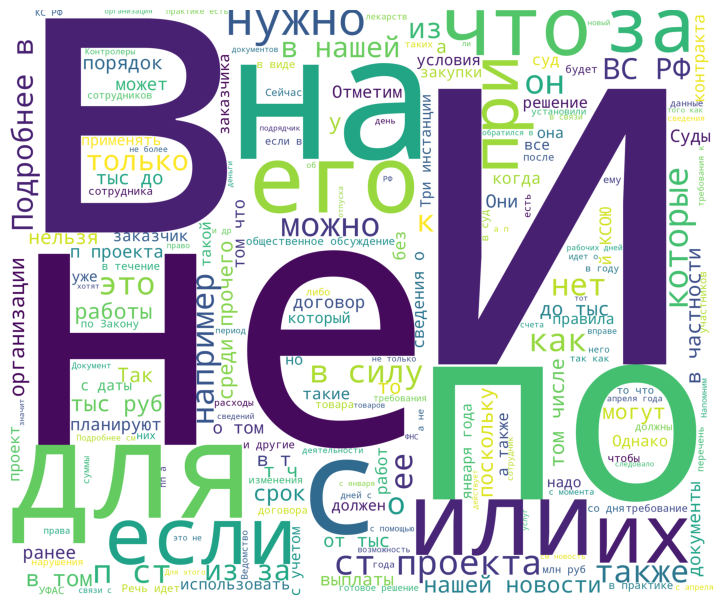

In [ ]:
def get_wordCloud(cloud):
    wordCloud = WordCloud(background_color='white',
                              stopwords=STOPWORDS,
                              width=3000,
                              height=2500,
                              max_words=200,
                              random_state=42
                         ).generate(cloud)
    return wordCloud
cloud = get_str(df2['Text'].to_list())
showWordCloud = get_wordCloud(cloud)
fig = plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.imshow(showWordCloud)
plt.axis('off')
plt.subplot(1, 2, 1)

Очищаем повторяющиеся стоп-слова, знаки препинания и приводим все слова к нижнему регистру

In [ ]:
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
from string import punctuation
russian_stopwords = stopwords.words("russian")

try:
  df2['Text'] = df2['Text'].map(lambda x: x.lower())
except:
  pass
df2['Text'] = df2['Text'].map(lambda x: re.split('[,. :()-;"1234567890n—]|\xa0', x))
df2['Text'] = df2['Text'].map(lambda x: [token for token in x if token not in russian_stopwords\
                                                                  and token != " " \
                                                                  and token.strip() not in punctuation])
df2['Text'] = df2['Text'].map(lambda x: ' '.join(x))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
<ipython-input-12-f89a62267b7f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Text'] = df2['Text'].map(lambda x: x.lower())
<ipython-input-12-f89a62267b7f>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Text'] = df2['Text'].map(lambda x: re.split('[,. :()-;"1234567890n—]|\xa0', x))
<ipython-input-12-f89a62267b7f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

Отрисовываем очищенное облако

<Axes: >

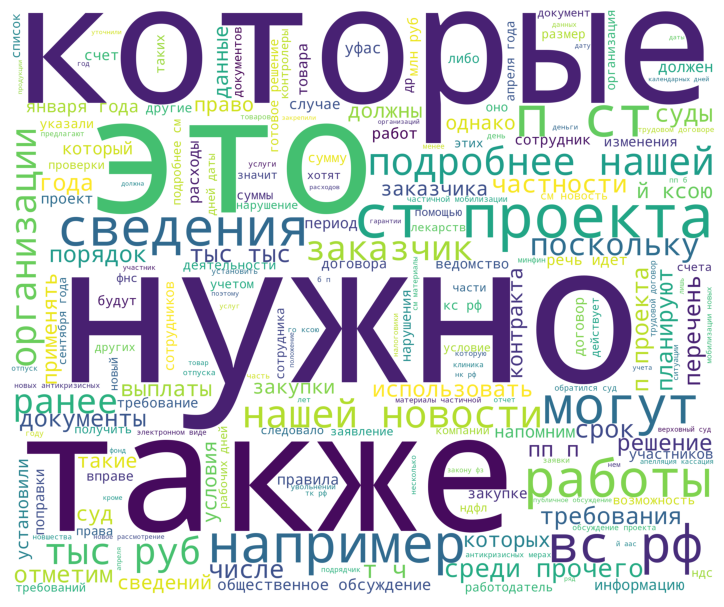

In [ ]:
cloud = get_str(df2['Text'].to_list())
showWordCloud = get_wordCloud(cloud)
fig = plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.imshow(showWordCloud)
plt.axis('off')
plt.subplot(1, 2, 1)

Данные почищены. Переходим к построению моделей

# Часть 3. Построение моделей

Импортируем библиотеки для моделей и оценки их работы

In [ ]:
import sklearn as sk
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

Разделяем данные на тестувую и обучающую выборки

In [ ]:
Y = df2["Profession"]
X = df2.drop("Profession", axis='columns')
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=1)

Импортируем модели

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier

Костыль для приведения данных к корректному виду

In [ ]:
X_train = x_train['Text']
X_test = x_test['Text']

Переводим текст в векторы и тренируем модели.

In [ ]:
from sklearn.linear_model import SGDClassifier
rfc_ppl_clf = Pipeline([
    ('tfidf', TfidfVectorizer(lowercase=False)),
    ('rfc_clf', RandomForestClassifier(n_estimators=1000))])
knb_ppl_clf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('knb_clf', KNeighborsClassifier(n_neighbors=10))])
rfc_ppl_clf.fit(X_train, y_train)
knb_ppl_clf.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('knb_clf', KNeighborsClassifier(n_neighbors=10))])

Строим предсказания на ненастроенных моделях и оцениваем их

In [ ]:
prediction = rfc_ppl_clf.predict(X_test)
prediction1 = knb_ppl_clf.predict(X_test)
print(metrics.classification_report(prediction, y_test))
print(metrics.classification_report(prediction1, y_test))

              precision    recall  f1-score   support

         bdg       0.14      0.44      0.21         9
         buh       0.55      0.24      0.33        46
          gz       0.86      0.72      0.78        25
          hr       0.52      0.57      0.55        21
         jur       0.65      0.77      0.70        26
    medicine       0.73      0.83      0.78        23

    accuracy                           0.56       150
   macro avg       0.57      0.60      0.56       150
weighted avg       0.62      0.56      0.56       150

              precision    recall  f1-score   support

         bdg       0.17      0.62      0.27         8
         buh       0.70      0.41      0.52        34
          gz       1.00      0.70      0.82        30
          hr       0.65      0.52      0.58        29
         jur       0.58      0.60      0.59        30
    medicine       0.73      1.00      0.84        19

    accuracy                           0.61       150
   macro avg       0.64

С помощью кросс-валидации ищем аттрибуты, при которых модель будет лучше обучаться (случайный лес)

In [ ]:
params = {
    'rfc_clf__n_estimators': [i for i in range(0, 100, 20)],
    'rfc_clf__criterion': ['gini', 'entropy', 'log_loss'],
    'rfc_clf__max_depth': [i for i in range(0, 100, 20)],
    'rfc_clf__bootstrap': [True, False],
    'tfidf__strip_accents':['ascii', 'unicode', None],
    'tfidf__ngram_range':[(1,2), (2,3), (3,4)]
}
gs = GridSearchCV(rfc_ppl_clf, params, cv=3, scoring='accuracy', verbose=3)
ans = gs.fit(X_train, y_train)
ans.best_params_

Fitting 3 folds for each of 1350 candidates, totalling 4050 fits
[CV 1/3] END rfc_clf__bootstrap=True, rfc_clf__criterion=gini, rfc_clf__max_depth=0, rfc_clf__n_estimators=0, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=nan total time=   0.0s
[CV 2/3] END rfc_clf__bootstrap=True, rfc_clf__criterion=gini, rfc_clf__max_depth=0, rfc_clf__n_estimators=0, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=nan total time=   0.0s
[CV 3/3] END rfc_clf__bootstrap=True, rfc_clf__criterion=gini, rfc_clf__max_depth=0, rfc_clf__n_estimators=0, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=nan total time=   0.0s
[CV 1/3] END rfc_clf__bootstrap=True, rfc_clf__criterion=gini, rfc_clf__max_depth=0, rfc_clf__n_estimators=0, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=nan total time=   0.1s
[CV 2/3] END rfc_clf__bootstrap=True, rfc_clf__criterion=gini, rfc_clf__max_depth=0, rfc_clf__n_estimators=0, tfidf__ngram_range=(1, 2), tfidf__strip_acc

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
1458 fits failed out of a total of 4050.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
810 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py", line 340, in fit
    self._validate_params()
  File "/usr/local/lib/python3.10/dist-p

{'rfc_clf__bootstrap': False,
 'rfc_clf__criterion': 'gini',
 'rfc_clf__max_depth': 40,
 'rfc_clf__n_estimators': 80,
 'tfidf__ngram_range': (1, 2),
 'tfidf__strip_accents': None}

Строим предсказание на настроенной модели

In [ ]:
pred = gs.best_estimator_.predict(X_test)
print(metrics.classification_report(pred, y_test))

              precision    recall  f1-score   support

         bdg       0.17      0.50      0.26        10
         buh       0.55      0.24      0.33        46
          gz       0.86      0.78      0.82        23
          hr       0.48      0.65      0.55        17
         jur       0.81      0.78      0.79        32
    medicine       0.73      0.86      0.79        22

    accuracy                           0.59       150
   macro avg       0.60      0.64      0.59       150
weighted avg       0.65      0.59      0.59       150



Повторяем предыдущий пункт для ближайших соседей

In [ ]:
params = {
    'knb_clf__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'knb_clf__n_neighbors': [i for i in range(0, 100, 20)],
    'knb_clf__leaf_size': [i for i in range(0, 100, 20)],
    'tfidf__strip_accents':['ascii', 'unicode', None],
    'tfidf__ngram_range':[(1,2), (2,3), (3,4)]
}
gs1 = GridSearchCV(knb_ppl_clf, params, cv=3, scoring='accuracy', verbose=3)
ans1 = gs1.fit(X_train, y_train)
ans1.best_params_

Fitting 3 folds for each of 900 candidates, totalling 2700 fits
[CV 1/3] END knb_clf__algorithm=auto, knb_clf__leaf_size=0, knb_clf__n_neighbors=0, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=nan total time=   0.0s
[CV 2/3] END knb_clf__algorithm=auto, knb_clf__leaf_size=0, knb_clf__n_neighbors=0, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=nan total time=   0.0s
[CV 3/3] END knb_clf__algorithm=auto, knb_clf__leaf_size=0, knb_clf__n_neighbors=0, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=nan total time=   0.0s
[CV 1/3] END knb_clf__algorithm=auto, knb_clf__leaf_size=0, knb_clf__n_neighbors=0, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=nan total time=   0.6s
[CV 2/3] END knb_clf__algorithm=auto, knb_clf__leaf_size=0, knb_clf__n_neighbors=0, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=nan total time=   0.3s
[CV 3/3] END knb_clf__algorithm=auto, knb_clf__leaf_size=0, knb_clf__n_neighbors=0, tfi

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=20, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.153 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=20, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.153 total time=   0.0s
[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=20, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.680 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=20, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.720 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=20, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.653 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=20, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.680 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=20, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.727 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=20, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.640 total time=   0.7s
[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=20, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.160 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=20, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.180 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=20, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.153 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=20, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.573 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=20, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.607 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=20, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.567 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=20, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.560 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=20, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.620 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=20, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.580 total time=   1.0s
[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=20, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.160 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=20, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.180 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=20, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.153 total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=20, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.407 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=20, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.380 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=20, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.293 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=20, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.407 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=20, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.380 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=20, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.293 total time=   0.5s
[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=40, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.160 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=40, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.187 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=40, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.200 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=40, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.673 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=40, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.653 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=40, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.673 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=40, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.673 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=40, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.660 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=40, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.673 total time=   0.7s
[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=40, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.160 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=40, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.173 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=40, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.153 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=40, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.520 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=40, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.493 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=40, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.493 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=40, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.507 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=40, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.553 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=40, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.507 total time=   1.0s
[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=40, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.160 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=40, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.173 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=40, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.153 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=40, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.367 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=40, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.280 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=40, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.313 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=40, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.367 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=40, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.280 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=40, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.320 total time=   0.5s
[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=60, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.160 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=60, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.167 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=60, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.160 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=60, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.640 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=60, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.660 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=60, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.660 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=60, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.620 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=60, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.660 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=60, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.647 total time=   0.7s
[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=60, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.160 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=60, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.180 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=60, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.160 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=60, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.460 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=60, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.473 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=60, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.493 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=60, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.453 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=60, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.487 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=60, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.513 total time=   1.0s
[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=60, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.160 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=60, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.180 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=60, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.160 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=60, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.253 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=60, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.220 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=60, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.373 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=60, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.247 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=60, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.227 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=60, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.413 total time=   0.5s
[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=80, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.160 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=80, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.167 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=80, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.160 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=80, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.627 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=80, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.633 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=80, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.627 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=80, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.633 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=80, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.647 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=80, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.620 total time=   0.7s
[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=80, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.160 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=80, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.180 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=80, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.160 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=80, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.420 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=80, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.460 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=80, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.480 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=80, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.407 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=80, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.473 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=80, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.487 total time=   0.9s
[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=80, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.160 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=80, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.180 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=80, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.160 total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=80, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.193 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=80, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.193 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=80, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.353 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=80, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.193 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=80, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.213 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=80, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.380 total time=   0.5s
[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=0, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=nan total time=   0.0s
[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=0, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=nan total time=   0.0s
[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=0, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=nan total time=   0.0s
[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=0, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=nan total time=   0.1s
[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=0, tfidf__ngram_range=(1, 2), tfid

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=20, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.680 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=20, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.720 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=20, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.653 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=20, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.680 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=20, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.727 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=20, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.640 total time=   0.7s
[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=20, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.160 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=20, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.180 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=20, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.153 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=20, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.573 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=20, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.607 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=20, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.567 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=20, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.560 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=20, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.620 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=20, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.580 total time=   0.6s
[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=20, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.160 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=20, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.180 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=20, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.153 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=20, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.407 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=20, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.380 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=20, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.293 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=20, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.407 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=20, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.380 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=20, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.293 total time=   0.5s
[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=40, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.160 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=40, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.187 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=40, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.200 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=40, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.673 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=40, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.653 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=40, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.673 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=40, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.673 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=40, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.660 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=40, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.673 total time=   0.7s
[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=40, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.160 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=40, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.173 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=40, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.153 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=40, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.520 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=40, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.493 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=40, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.493 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=40, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.507 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=40, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.553 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=40, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.507 total time=   0.6s
[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=40, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.160 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=40, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.173 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=40, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.153 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=40, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.367 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=40, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.280 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=40, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.313 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=40, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.367 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=40, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.280 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=40, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.320 total time=   0.5s
[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=60, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.160 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=60, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.167 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=60, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.160 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=60, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.640 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=60, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.660 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=60, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.660 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=60, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.620 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=60, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.660 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=60, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.647 total time=   0.7s
[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=60, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.160 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=60, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.180 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=60, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.160 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=60, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.460 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=60, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.473 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=60, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.493 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=60, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.453 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=60, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.487 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=60, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.513 total time=   0.6s
[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=60, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.160 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=60, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.180 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=60, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.160 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=60, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.253 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=60, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.220 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=60, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.373 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=60, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.247 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=60, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.227 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=60, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.413 total time=   0.5s
[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=80, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.160 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=80, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.167 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=80, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.160 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=80, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.627 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=80, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.633 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=80, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.627 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=80, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.633 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=80, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.647 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=80, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.620 total time=   0.7s
[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=80, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.160 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=80, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.180 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=80, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.160 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=80, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.420 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=80, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.460 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=80, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.480 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=80, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.407 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=80, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.473 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=80, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.487 total time=   0.6s
[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=80, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.160 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=80, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.180 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=80, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.160 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=80, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.193 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=80, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.193 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=80, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.353 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=80, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.193 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=80, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.213 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=80, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.380 total time=   0.5s
[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=0, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=nan total time=   0.0s
[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=0, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=nan total time=   0.0s
[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=0, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=nan total time=   0.0s
[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=0, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=nan total time=   0.1s
[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=0, tfidf__ngram_range=(1, 2), tfid

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=20, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.680 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=20, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.720 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=20, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.653 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=20, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.680 total time=   1.3s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=20, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.727 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=20, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.640 total time=   0.7s
[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=20, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.160 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=20, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.180 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=20, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.153 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=20, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.573 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=20, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.607 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=20, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.567 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=20, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.560 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=20, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.620 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=20, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.580 total time=   0.6s
[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=20, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.160 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=20, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.180 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=20, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.153 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=20, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.407 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=20, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.380 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=20, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.293 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=20, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.407 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=20, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.380 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=20, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.293 total time=   0.5s
[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=40, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.160 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=40, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.187 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=40, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.200 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=40, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.673 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=40, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.653 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=40, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.673 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=40, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.673 total time=   1.3s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=40, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.660 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=40, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.673 total time=   0.7s
[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=40, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.160 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=40, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.173 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=40, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.153 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=40, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.520 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=40, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.493 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=40, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.493 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=40, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.507 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=40, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.553 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=40, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.507 total time=   0.6s
[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=40, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.160 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=40, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.173 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=40, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.153 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=40, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.367 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=40, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.280 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=40, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.313 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=40, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.367 total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=40, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.280 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=40, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.320 total time=   0.5s
[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=60, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.160 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=60, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.167 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=60, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.160 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=60, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.640 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=60, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.660 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=60, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.660 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=60, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.620 total time=   1.4s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=60, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.660 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=60, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.647 total time=   0.7s
[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=60, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.160 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=60, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.180 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=60, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.160 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=60, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.460 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=60, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.473 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=60, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.493 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=60, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.453 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=60, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.487 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=60, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.513 total time=   0.6s
[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=60, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.160 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=60, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.180 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=60, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.160 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=60, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.253 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=60, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.220 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=60, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.373 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=60, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.247 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=60, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.227 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=60, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.413 total time=   0.5s
[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=80, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.160 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=80, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.167 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=80, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.160 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=80, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.627 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=80, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.633 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=80, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.627 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=80, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.633 total time=   1.2s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=80, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.647 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=80, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.620 total time=   0.7s
[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=80, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.160 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=80, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.180 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=80, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.160 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=80, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.420 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=80, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.460 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=80, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.480 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=80, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.407 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=80, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.473 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=80, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.487 total time=   0.6s
[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=80, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.160 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=80, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.180 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=80, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.160 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=80, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.193 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=80, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.193 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=80, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.353 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=80, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.193 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=80, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.213 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=80, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.380 total time=   0.5s
[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=0, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=nan total time=   0.0s
[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=0, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=nan total time=   0.0s
[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=0, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=nan total time=   0.0s
[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=0, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=nan total time=   0.1s
[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=0, tfidf__ngram_range=(1, 2), tfid

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=20, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.680 total time=   1.2s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=20, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.720 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=20, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.653 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=20, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.680 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=20, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.727 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=20, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.640 total time=   0.7s
[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=20, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.160 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=20, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.180 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=20, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.153 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=20, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.573 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=20, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.607 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=20, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.567 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=20, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.560 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=20, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.620 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=20, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.580 total time=   0.6s
[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=20, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.160 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=20, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.180 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=20, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.153 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=20, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.407 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=20, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.380 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=20, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.293 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=20, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.407 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=20, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.380 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=20, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.293 total time=   0.8s
[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=40, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.160 total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=40, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.187 total time=   0.1s
[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=40, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.200 total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=40, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.673 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=40, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.653 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=40, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.673 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=40, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.673 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=40, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.660 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=40, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.673 total time=   0.7s
[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=40, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.160 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=40, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.173 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=40, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.153 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=40, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.520 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=40, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.493 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=40, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.493 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=40, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.507 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=40, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.553 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=40, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.507 total time=   0.6s
[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=40, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.160 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=40, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.173 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=40, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.153 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=40, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.367 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=40, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.280 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=40, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.313 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=40, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.367 total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=40, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.280 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=40, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.320 total time=   0.8s
[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=60, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.160 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=60, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.167 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=60, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.160 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=60, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.640 total time=   1.3s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=60, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.660 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=60, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.660 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=60, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.620 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=60, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.660 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=60, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.647 total time=   0.7s
[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=60, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.160 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=60, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.180 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=60, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.160 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=60, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.460 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=60, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.473 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=60, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.493 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=60, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.453 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=60, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.487 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=60, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.513 total time=   0.5s
[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=60, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.160 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=60, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.180 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=60, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.160 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=60, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.253 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=60, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.220 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=60, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.373 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=60, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.247 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=60, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.227 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=60, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.413 total time=   0.5s
[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=80, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.160 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=80, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.167 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=80, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.160 total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=80, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.627 total time=   1.4s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=80, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.633 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=80, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.627 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=80, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.633 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=80, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.647 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=80, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.620 total time=   0.7s
[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=80, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.160 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=80, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.180 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=80, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.160 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=80, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.420 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=80, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.460 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=80, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.480 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=80, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.407 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=80, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.473 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=80, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.487 total time=   0.5s
[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=80, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.160 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=80, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.180 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=80, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.160 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=80, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.193 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=80, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.193 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=80, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.353 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=80, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.193 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=80, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.213 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=80, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.380 total time=   0.5s
[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=0, knb_clf__n_neighbors=0, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=nan total time=   0.0s
[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=0, knb_clf__n_neighbors=0, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=nan total time=   0.0s
[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=0, knb_clf__n_neighbors=0, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=nan total time=   0.0s
[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=0, knb_clf__n_neighbors=0, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=nan total time=   0.1s
[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=0, knb_clf__n_neighbors=0, tfidf__ngram_range=(1, 2), tfidf__strip_accent

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=20, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.680 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=20, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.720 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=20, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.653 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=20, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.680 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=20, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.727 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=20, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.640 total time=   0.7s
[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=20, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.160 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=20, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.180 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=20, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.153 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=20, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.573 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=20, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.607 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=20, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.567 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=20, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.560 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=20, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.620 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=20, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.580 total time=   0.5s
[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=20, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.160 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=20, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.180 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=20, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.153 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=20, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.407 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=20, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.380 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=20, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.293 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=20, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.407 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=20, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.380 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=20, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.293 total time=   0.5s
[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=40, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.160 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=40, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.187 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=40, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.200 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=40, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.673 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=40, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.653 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=40, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.673 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=40, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.673 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=40, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.660 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=40, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.673 total time=   0.7s
[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=40, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.160 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=40, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.173 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=40, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.153 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=40, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.520 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=40, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.493 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=40, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.493 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=40, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.507 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=40, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.553 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=40, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.507 total time=   0.5s
[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=40, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.160 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=40, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.173 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=40, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.153 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=40, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.367 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=40, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.280 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=40, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.313 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=40, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.367 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=40, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.280 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=40, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.320 total time=   0.5s
[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=60, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.160 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=60, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.167 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=60, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.160 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=60, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.640 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=60, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.660 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=60, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.660 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=60, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.620 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=60, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.660 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=60, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.647 total time=   0.7s
[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=60, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.160 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=60, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.180 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=60, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.160 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=60, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.460 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=60, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.473 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=60, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.493 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=60, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.453 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=60, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.487 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=60, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.513 total time=   0.6s
[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=60, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.160 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=60, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.180 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=60, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.160 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=60, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.253 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=60, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.220 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=60, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.373 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=60, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.247 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=60, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.227 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=60, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.413 total time=   0.5s
[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=80, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.160 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=80, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.167 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=80, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.160 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=80, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.627 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=80, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.633 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=80, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.627 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=80, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.633 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=80, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.647 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=80, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.620 total time=   0.7s
[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=80, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.160 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=80, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.180 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=80, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.160 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=80, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.420 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=80, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.460 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=80, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.480 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=80, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.407 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=80, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.473 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=80, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.487 total time=   0.6s
[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=80, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.160 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=80, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.180 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=80, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.160 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=80, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.193 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=80, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.193 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=80, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.353 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=80, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.193 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=80, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.213 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=80, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.380 total time=   0.5s
[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=0, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=nan total time=   0.0s
[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=0, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=nan total time=   0.0s
[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=0, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=nan total time=   0.0s
[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=0, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=nan total time=   0.1s
[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=0, tfidf__ngram_range=(1, 2), tfidf__strip_acc

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=20, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.153 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=20, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.153 total time=   0.0s
[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=20, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.680 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=20, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.720 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=20, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.653 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=20, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.680 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=20, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.727 total time=   1.3s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=20, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.640 total time=   0.7s
[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=20, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.160 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=20, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.180 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=20, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.153 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=20, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.573 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=20, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.607 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=20, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.567 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=20, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.560 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=20, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.620 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=20, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.580 total time=   0.6s
[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=20, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.160 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=20, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.180 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=20, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.153 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=20, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.407 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=20, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.380 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=20, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.293 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=20, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.407 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=20, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.380 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=20, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.293 total time=   0.5s
[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=40, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.160 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=40, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.187 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=40, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.200 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=40, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.673 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=40, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.653 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=40, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.673 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=40, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.673 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=40, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.660 total time=   1.2s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=40, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.673 total time=   0.8s
[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=40, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.160 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=40, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.173 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=40, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.153 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=40, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.520 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=40, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.493 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=40, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.493 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=40, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.507 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=40, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.553 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=40, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.507 total time=   0.5s
[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=40, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.160 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=40, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.173 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=40, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.153 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=40, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.367 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=40, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.280 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=40, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.313 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=40, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.367 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=40, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.280 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=40, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.320 total time=   0.5s
[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=60, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.160 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=60, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.167 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=60, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.160 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=60, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.640 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=60, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.660 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=60, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.660 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=60, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.620 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=60, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.660 total time=   1.3s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=60, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.647 total time=   0.9s
[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=60, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.160 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=60, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.180 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=60, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.160 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=60, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.460 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=60, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.473 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=60, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.493 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=60, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.453 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=60, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.487 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=60, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.513 total time=   0.5s
[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=60, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.160 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=60, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.180 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=60, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.160 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=60, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.253 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=60, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.220 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=60, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.373 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=60, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.247 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=60, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.227 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=60, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.413 total time=   0.5s
[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=80, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.160 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=80, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.167 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=80, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.160 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=80, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.627 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=80, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.633 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=80, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.627 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=80, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.633 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=80, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.647 total time=   1.3s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=80, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.620 total time=   0.9s
[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=80, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.160 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=80, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.180 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=80, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.160 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=80, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.420 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=80, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.460 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=80, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.480 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=80, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.407 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=80, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.473 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=80, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.487 total time=   0.6s
[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=80, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.160 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=80, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.180 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=80, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.160 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=80, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.193 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=80, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.193 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=80, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.353 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=80, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.193 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=80, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.213 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=80, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.380 total time=   0.5s
[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=0, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=nan total time=   0.0s
[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=0, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=nan total time=   0.0s
[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=0, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=nan total time=   0.0s
[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=0, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=nan total time=   0.1s
[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=0, tfidf__ngram_range=(1, 2), tfidf__strip_acc

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=20, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.160 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=20, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.153 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=20, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.153 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=20, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.680 total time=   1.3s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=20, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.720 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=20, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.653 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=20, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.680 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=20, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.727 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=20, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.640 total time=   0.7s
[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=20, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.160 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=20, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.180 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=20, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.153 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=20, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.573 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=20, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.607 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=20, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.567 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=20, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.560 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=20, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.620 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=20, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.580 total time=   0.6s
[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=20, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.160 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=20, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.180 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=20, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.153 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=20, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.407 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=20, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.380 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=20, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.293 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=20, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.407 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=20, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.380 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=20, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.293 total time=   0.7s
[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=40, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.160 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=40, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.187 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=40, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.200 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=40, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.673 total time=   1.3s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=40, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.653 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=40, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.673 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=40, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.673 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=40, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.660 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=40, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.673 total time=   0.7s
[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=40, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.160 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=40, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.173 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=40, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.153 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=40, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.520 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=40, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.493 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=40, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.493 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=40, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.507 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=40, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.553 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=40, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.507 total time=   0.6s
[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=40, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.160 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=40, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.173 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=40, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.153 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=40, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.367 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=40, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.280 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=40, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.313 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=40, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.367 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=40, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.280 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=40, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.320 total time=   0.7s
[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=60, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.160 total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=60, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.167 total time=   0.2s
[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=60, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.160 total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=60, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.640 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=60, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.660 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=60, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.660 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=60, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.620 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=60, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.660 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=60, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.647 total time=   0.7s
[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=60, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.160 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=60, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.180 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=60, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.160 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=60, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.460 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=60, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.473 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=60, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.493 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=60, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.453 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=60, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.487 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=60, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.513 total time=   0.6s
[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=60, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.160 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=60, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.180 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=60, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.160 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=60, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.253 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=60, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.220 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=60, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.373 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=60, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.247 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=60, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.227 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=60, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.413 total time=   0.9s
[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=80, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.160 total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=80, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.167 total time=   0.1s
[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=80, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.160 total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=80, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.627 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=80, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.633 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=80, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.627 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=80, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.633 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=80, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.647 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=80, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.620 total time=   0.7s
[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=80, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.160 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=80, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.180 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=80, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.160 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=80, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.420 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=80, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.460 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=80, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.480 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=80, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.407 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=80, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.473 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=80, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.487 total time=   0.6s
[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=80, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.160 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=80, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.180 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=80, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.160 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=80, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.193 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=80, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.193 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=80, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.353 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=80, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.193 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=80, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.213 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=80, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.380 total time=   0.8s
[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=0, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=nan total time=   0.0s
[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=0, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=nan total time=   0.0s
[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=0, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=nan total time=   0.0s
[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=0, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=nan total time=   0.1s
[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=0, tfidf__ngram_range=(1, 2), tfidf__strip_acc

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=20, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.153 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=20, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.153 total time=   0.0s
[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=20, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.680 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=20, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.720 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=20, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.653 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=20, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.680 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=20, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.727 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=20, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.640 total time=   0.7s
[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=20, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.160 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=20, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.180 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=20, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.153 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=20, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.573 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=20, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.607 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=20, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.567 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=20, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.560 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=20, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.620 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=20, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.580 total time=   0.7s
[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=20, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.160 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=20, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.180 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=20, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.153 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=20, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.407 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=20, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.380 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=20, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.293 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=20, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.407 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=20, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.380 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=20, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.293 total time=   0.5s
[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=40, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.160 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=40, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.187 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=40, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.200 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=40, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.673 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=40, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.653 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=40, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.673 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=40, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.673 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=40, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.660 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=40, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.673 total time=   0.7s
[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=40, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.160 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=40, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.173 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=40, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.153 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=40, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.520 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=40, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.493 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=40, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.493 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=40, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.507 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=40, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.553 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=40, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.507 total time=   0.6s
[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=40, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.160 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=40, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.173 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=40, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.153 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=40, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.367 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=40, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.280 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=40, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.313 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=40, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.367 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=40, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.280 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=40, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.320 total time=   0.5s
[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=60, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.160 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=60, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.167 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=60, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.160 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=60, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.640 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=60, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.660 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=60, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.660 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=60, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.620 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=60, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.660 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=60, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.647 total time=   0.7s
[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=60, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.160 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=60, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.180 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=60, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.160 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=60, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.460 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=60, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.473 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=60, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.493 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=60, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.453 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=60, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.487 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=60, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.513 total time=   0.6s
[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=60, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.160 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=60, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.180 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=60, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.160 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=60, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.253 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=60, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.220 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=60, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.373 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=60, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.247 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=60, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.227 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=60, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.413 total time=   0.5s
[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=80, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.160 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=80, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.167 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=80, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.160 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=80, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.627 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=80, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.633 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=80, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.627 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=80, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.633 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=80, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.647 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=80, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.620 total time=   0.7s
[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=80, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.160 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=80, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.180 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=80, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.160 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=80, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.420 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=80, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.460 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=80, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.480 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=80, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.407 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=80, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.473 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=80, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.487 total time=   0.6s
[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=80, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.160 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=80, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.180 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=80, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.160 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=80, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.193 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=80, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.193 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=80, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.353 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=80, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.193 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=80, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.213 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=80, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.380 total time=   0.5s
[CV 1/3] END knb_clf__algorithm=brute, knb_clf__leaf_size=0, knb_clf__n_neighbors=0, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=nan total time=   0.0s
[CV 2/3] END knb_clf__algorithm=brute, knb_clf__leaf_size=0, knb_clf__n_neighbors=0, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=nan total time=   0.0s
[CV 3/3] END knb_clf__algorithm=brute, knb_clf__leaf_size=0, knb_clf__n_neighbors=0, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=nan total time=   0.0s
[CV 1/3] END knb_clf__algorithm=brute, knb_clf__leaf_size=0, knb_clf__n_neighbors=0, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=nan total time=   0.1s
[CV 2/3] END knb_clf__algorithm=brute, knb_clf__leaf_size=0, knb_clf__n_neighbors=0, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, 

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
972 fits failed out of a total of 2700.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
540 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py", line 213, in fit
    self._validate_params()
  File "/usr/local/lib/python3.1

{'knb_clf__algorithm': 'auto',
 'knb_clf__leaf_size': 20,
 'knb_clf__n_neighbors': 20,
 'tfidf__ngram_range': (1, 2),
 'tfidf__strip_accents': 'unicode'}

In [ ]:
pred1 = gs1.best_estimator_.predict(X_test)
print(metrics.classification_report(pred1, y_test))

              precision    recall  f1-score   support

         bdg       0.21      0.55      0.30        11
         buh       0.65      0.46      0.54        28
          gz       0.90      0.68      0.78        28
          hr       0.65      0.56      0.60        27
         jur       0.77      0.63      0.70        38
    medicine       0.69      1.00      0.82        18

    accuracy                           0.63       150
   macro avg       0.65      0.65      0.62       150
weighted avg       0.70      0.63      0.65       150



В обоих случаях профессия бюджет (бухгалтер по бюджету) определяется плохо.
Тогда объединим бюджет и бухгалтера 

In [ ]:
arr = df2['Profession'].to_list()
for i in range(len(arr)):
  if arr[i] == 'bdg':
    arr[i] = 'buh'
df2['Profession'] = pd.Series(arr)

<ipython-input-33-b8ad74df4060>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Profession'] = pd.Series(arr)


buh         200
jur         100
hr          100
gz          100
medicine    100
Name: Profession, dtype: int64

Снова разделяем выборку на обучающую и тестовую

In [ ]:
Y = df2["Profession"]
X = df2.drop("Profession", axis='columns')
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=1)

Костыль + тренировка моделей

In [ ]:
X_train = x_train['Text']
X_test = x_test['Text']
rfc_ppl_clf.fit(X_train, y_train)
knb_ppl_clf.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('knb_clf', KNeighborsClassifier(n_neighbors=10))])

Построение предсказаний на сырых моделях

In [ ]:
prediction = rfc_ppl_clf.predict(X_test)
prediction1 = knb_ppl_clf.predict(X_test)
print(metrics.classification_report(prediction, y_test))
print(metrics.classification_report(prediction1, y_test))

              precision    recall  f1-score   support

         buh       0.84      0.51      0.63        81
          gz       0.71      0.75      0.73        20
          hr       0.22      0.42      0.29        12
         jur       0.45      0.78      0.57        18
    medicine       0.62      0.84      0.71        19

    accuracy                           0.61       150
   macro avg       0.57      0.66      0.59       150
weighted avg       0.70      0.61      0.62       150

              precision    recall  f1-score   support

         buh       0.76      0.70      0.73        53
          gz       0.90      0.70      0.79        27
          hr       0.48      0.48      0.48        23
         jur       0.58      0.62      0.60        29
    medicine       0.69      1.00      0.82        18

    accuracy                           0.69       150
   macro avg       0.68      0.70      0.68       150
weighted avg       0.70      0.69      0.69       150



Подбор лучших параметров для случайного леса

In [ ]:
params = {
    'rfc_clf__n_estimators': [i for i in range(0, 100, 20)],
    'rfc_clf__criterion': ['gini', 'entropy', 'log_loss'],
    'rfc_clf__max_depth': [i for i in range(0, 100, 20)],
    'rfc_clf__bootstrap': [True, False],
    'tfidf__strip_accents':['ascii', 'unicode', None],
    'tfidf__ngram_range':[(1,2), (2,3), (3,4)]
}
gs = GridSearchCV(rfc_ppl_clf, params, cv=3, scoring='accuracy', verbose=3)
ans = gs.fit(X_train, y_train)
ans.best_params_

Fitting 3 folds for each of 1350 candidates, totalling 4050 fits
[CV 1/3] END rfc_clf__bootstrap=True, rfc_clf__criterion=gini, rfc_clf__max_depth=0, rfc_clf__n_estimators=0, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=nan total time=   0.0s
[CV 2/3] END rfc_clf__bootstrap=True, rfc_clf__criterion=gini, rfc_clf__max_depth=0, rfc_clf__n_estimators=0, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=nan total time=   0.0s
[CV 3/3] END rfc_clf__bootstrap=True, rfc_clf__criterion=gini, rfc_clf__max_depth=0, rfc_clf__n_estimators=0, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=nan total time=   0.0s
[CV 1/3] END rfc_clf__bootstrap=True, rfc_clf__criterion=gini, rfc_clf__max_depth=0, rfc_clf__n_estimators=0, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=nan total time=   0.2s
[CV 2/3] END rfc_clf__bootstrap=True, rfc_clf__criterion=gini, rfc_clf__max_depth=0, rfc_clf__n_estimators=0, tfidf__ngram_range=(1, 2), tfidf__strip_acc

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
1458 fits failed out of a total of 4050.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
810 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py", line 340, in fit
    self._validate_params()
  File "/usr/local/lib/python3.10/dist-p

{'rfc_clf__bootstrap': False,
 'rfc_clf__criterion': 'gini',
 'rfc_clf__max_depth': 60,
 'rfc_clf__n_estimators': 80,
 'tfidf__ngram_range': (1, 2),
 'tfidf__strip_accents': 'unicode'}

Построение предсказания на лучших параметрах

In [ ]:
pred = gs.best_estimator_.predict(X_test)
print(metrics.classification_report(pred, y_test))

              precision    recall  f1-score   support

         buh       0.90      0.64      0.75        69
          gz       0.81      0.77      0.79        22
          hr       0.35      0.62      0.44        13
         jur       0.58      0.75      0.65        24
    medicine       0.73      0.86      0.79        22

    accuracy                           0.71       150
   macro avg       0.67      0.73      0.69       150
weighted avg       0.76      0.71      0.72       150



Повторяем настройку для ближайших соседей

In [ ]:
params = {
    'knb_clf__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'knb_clf__n_neighbors': [i for i in range(0, 100, 20)],
    'knb_clf__leaf_size': [i for i in range(0, 100, 20)],
    'tfidf__strip_accents':['ascii', 'unicode', None],
    'tfidf__ngram_range':[(1,2), (2,3), (3,4)]
}
gs1 = GridSearchCV(knb_ppl_clf, params, cv=3, scoring='accuracy', verbose=3)
ans1 = gs1.fit(X_train, y_train)
ans1.best_params_

Fitting 3 folds for each of 900 candidates, totalling 2700 fits
[CV 1/3] END knb_clf__algorithm=auto, knb_clf__leaf_size=0, knb_clf__n_neighbors=0, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=nan total time=   0.0s
[CV 2/3] END knb_clf__algorithm=auto, knb_clf__leaf_size=0, knb_clf__n_neighbors=0, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=nan total time=   0.0s
[CV 3/3] END knb_clf__algorithm=auto, knb_clf__leaf_size=0, knb_clf__n_neighbors=0, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=nan total time=   0.0s
[CV 1/3] END knb_clf__algorithm=auto, knb_clf__leaf_size=0, knb_clf__n_neighbors=0, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=nan total time=   0.2s
[CV 2/3] END knb_clf__algorithm=auto, knb_clf__leaf_size=0, knb_clf__n_neighbors=0, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=nan total time=   0.3s
[CV 3/3] END knb_clf__algorithm=auto, knb_clf__leaf_size=0, knb_clf__n_neighbors=0, tfi

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=20, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.747 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=20, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.780 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=20, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.727 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=20, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.760 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=20, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.780 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=20, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.727 total time=   0.7s
[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=20, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=20, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=20, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.340 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=20, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.667 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=20, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.633 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=20, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.647 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=20, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.673 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=20, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.647 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=20, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.640 total time=   0.6s
[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=20, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=20, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=20, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.340 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=20, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.467 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=20, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.367 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=20, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.333 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=20, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.467 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=20, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.367 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=20, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.333 total time=   0.5s
[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=40, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=40, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=40, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.340 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=40, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.767 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=40, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.740 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=40, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.740 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=40, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.767 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=40, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.733 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=40, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.747 total time=   0.7s
[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=40, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=40, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=40, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.340 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=40, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.620 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=40, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.620 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=40, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.593 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=40, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.647 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=40, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.600 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=40, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.600 total time=   0.5s
[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=40, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=40, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=40, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.340 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=40, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.460 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=40, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.320 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=40, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.407 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=40, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.467 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=40, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.313 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=40, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.407 total time=   0.5s
[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=60, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=60, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=60, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.340 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=60, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.713 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=60, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.707 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=60, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.727 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=60, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.713 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=60, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.700 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=60, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.733 total time=   0.7s
[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=60, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=60, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=60, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.340 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=60, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.513 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=60, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.567 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=60, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.587 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=60, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.560 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=60, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.613 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=60, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.607 total time=   0.5s
[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=60, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=60, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=60, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.340 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=60, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.353 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=60, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.300 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=60, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.420 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=60, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.353 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=60, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.273 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=60, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.420 total time=   0.5s
[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=80, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=80, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=80, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.340 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=80, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.673 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=80, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.627 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=80, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.673 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=80, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.673 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=80, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.653 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=80, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.667 total time=   0.7s
[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=80, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=80, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=80, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.340 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=80, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.440 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=80, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.560 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=80, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.553 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=80, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.487 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=80, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.567 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=80, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.553 total time=   0.6s
[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=80, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=80, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=80, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.340 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=80, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.333 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=80, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.407 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=80, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.340 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=80, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.333 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=80, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.407 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=80, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.340 total time=   0.6s
[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=0, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=nan total time=   0.0s
[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=0, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=nan total time=   0.0s
[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=0, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=nan total time=   0.0s
[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=0, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=nan total time=   0.1s
[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=0, tfidf__ngram_range=(1, 2), tfid

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=20, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=20, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=20, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.340 total time=   0.0s
[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=20, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.747 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=20, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.780 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=20, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.727 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=20, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.760 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=20, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.780 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=20, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.727 total time=   0.7s
[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=20, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=20, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=20, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.340 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=20, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.667 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=20, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.633 total time=   1.2s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=20, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.647 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=20, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.673 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=20, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.647 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=20, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.640 total time=   0.5s
[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=20, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=20, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=20, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.340 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=20, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.467 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=20, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.367 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=20, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.333 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=20, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.467 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=20, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.367 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=20, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.333 total time=   0.6s
[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=40, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=40, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=40, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.340 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=40, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.767 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=40, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.740 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=40, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.740 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=40, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.767 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=40, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.733 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=40, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.747 total time=   0.7s
[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=40, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=40, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=40, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.340 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=40, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.620 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=40, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.620 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=40, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.593 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=40, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.647 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=40, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.600 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=40, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.600 total time=   0.6s
[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=40, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=40, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=40, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.340 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=40, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.460 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=40, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.320 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=40, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.407 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=40, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.467 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=40, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.313 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=40, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.407 total time=   0.5s
[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=60, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=60, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=60, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.340 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=60, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.713 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=60, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.707 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=60, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.727 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=60, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.713 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=60, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.700 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=60, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.733 total time=   1.2s
[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=60, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.333 total time=   0.1s
[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=60, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=60, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.340 total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=60, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.513 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=60, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.567 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=60, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.587 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=60, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.560 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=60, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.613 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=60, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.607 total time=   0.6s
[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=60, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=60, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=60, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.340 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=60, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.353 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=60, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.300 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=60, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.420 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=60, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.353 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=60, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.273 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=60, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.420 total time=   0.5s
[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=80, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=80, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=80, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.340 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=80, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.673 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=80, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.627 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=80, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.673 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=80, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.673 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=80, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.653 total time=   1.2s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=80, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.667 total time=   1.2s
[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=80, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=80, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=80, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.340 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=80, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.440 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=80, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.560 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=80, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.553 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=80, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.487 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=80, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.567 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=80, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.553 total time=   0.6s
[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=80, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=80, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=80, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.340 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=80, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.333 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=80, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.407 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=80, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.340 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=80, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.333 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=80, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.407 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=80, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.340 total time=   0.5s
[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=0, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=nan total time=   0.0s
[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=0, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=nan total time=   0.0s
[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=0, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=nan total time=   0.0s
[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=0, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=nan total time=   0.1s
[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=0, tfidf__ngram_range=(1, 2), tfid

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=20, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.747 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=20, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.780 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=20, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.727 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=20, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.760 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=20, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.780 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=20, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.727 total time=   0.8s
[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=20, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=20, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=20, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.340 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=20, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.667 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=20, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.633 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=20, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.647 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=20, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.673 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=20, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.647 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=20, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.640 total time=   0.6s
[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=20, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=20, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=20, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.340 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=20, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.467 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=20, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.367 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=20, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.333 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=20, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.467 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=20, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.367 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=20, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.333 total time=   0.9s
[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=40, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.333 total time=   0.1s
[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=40, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=40, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.340 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=40, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.767 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=40, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.740 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=40, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.740 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=40, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.767 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=40, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.733 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=40, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.747 total time=   0.7s
[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=40, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=40, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=40, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.340 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=40, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.620 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=40, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.620 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=40, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.593 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=40, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.647 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=40, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.600 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=40, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.600 total time=   0.6s
[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=40, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=40, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=40, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.340 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=40, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.460 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=40, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.320 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=40, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.407 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=40, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.467 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=40, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.313 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=40, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.407 total time=   0.6s
[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=60, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=60, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=60, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.340 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=60, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.713 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=60, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.707 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=60, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.727 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=60, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.713 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=60, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.700 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=60, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.733 total time=   0.7s
[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=60, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=60, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=60, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.340 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=60, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.513 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=60, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.567 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=60, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.587 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=60, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.560 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=60, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.613 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=60, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.607 total time=   0.6s
[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=60, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=60, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=60, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.340 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=60, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.353 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=60, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.300 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=60, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.420 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=60, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.353 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=60, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.273 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=60, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.420 total time=   0.5s
[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=80, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=80, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=80, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.340 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=80, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.673 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=80, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.627 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=80, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.673 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=80, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.673 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=80, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.653 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=80, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.667 total time=   0.8s
[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=80, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=80, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=80, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.340 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=80, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.440 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=80, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.560 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=80, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.553 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=80, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.487 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=80, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.567 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=80, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.553 total time=   0.6s
[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=80, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=80, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=80, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.340 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=80, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.333 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=80, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.407 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=80, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.340 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=80, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.333 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=80, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.407 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=80, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.340 total time=   0.6s
[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=0, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=nan total time=   0.0s
[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=0, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=nan total time=   0.0s
[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=0, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=nan total time=   0.0s
[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=0, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=nan total time=   0.1s
[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=0, tfidf__ngram_range=(1, 2), tfid

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=20, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.747 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=20, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.780 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=20, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.727 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=20, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.760 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=20, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.780 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=20, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.727 total time=   0.7s
[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=20, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=20, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=20, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.340 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=20, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.667 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=20, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.633 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=20, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.647 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=20, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.673 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=20, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.647 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=20, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.640 total time=   0.6s
[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=20, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=20, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=20, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.340 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=20, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.467 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=20, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.367 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=20, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.333 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=20, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.467 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=20, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.367 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=20, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.333 total time=   0.5s
[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=40, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=40, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=40, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.340 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=40, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.767 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=40, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.740 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=40, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.740 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=40, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.767 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=40, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.733 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=40, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.747 total time=   0.7s
[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=40, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=40, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=40, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.340 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=40, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.620 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=40, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.620 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=40, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.593 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=40, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.647 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=40, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.600 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=40, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.600 total time=   0.6s
[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=40, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=40, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=40, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.340 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=40, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.460 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=40, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.320 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=40, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.407 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=40, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.467 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=40, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.313 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=40, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.407 total time=   0.5s
[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=60, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=60, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=60, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.340 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=60, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.713 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=60, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.707 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=60, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.727 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=60, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.713 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=60, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.700 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=60, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.733 total time=   0.8s
[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=60, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=60, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=60, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.340 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=60, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.513 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=60, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.567 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=60, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.587 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=60, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.560 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=60, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.613 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=60, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.607 total time=   0.6s
[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=60, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=60, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=60, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.340 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=60, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.353 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=60, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.300 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=60, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.420 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=60, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.353 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=60, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.273 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=60, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.420 total time=   0.5s
[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=80, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=80, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=80, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.340 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=80, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.673 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=80, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.627 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=80, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.673 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=80, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.673 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=80, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.653 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=80, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.667 total time=   0.8s
[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=80, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.333 total time=   0.1s
[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=80, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=80, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.340 total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=80, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.440 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=80, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.560 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=80, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.553 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=80, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.487 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=80, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.567 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=80, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.553 total time=   0.6s
[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=80, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=80, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=80, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.340 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=80, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.333 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=80, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.407 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=80, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.340 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=80, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.333 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=80, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.407 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=ball_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=80, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.340 total time=   0.5s
[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=0, knb_clf__n_neighbors=0, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=nan total time=   0.0s
[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=0, knb_clf__n_neighbors=0, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=nan total time=   0.0s
[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=0, knb_clf__n_neighbors=0, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=nan total time=   0.0s
[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=0, knb_clf__n_neighbors=0, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=nan total time=   0.1s
[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=0, knb_clf__n_neighbors=0, tfidf__ngram_range=(1, 2), tfidf__strip_accent

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=20, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.747 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=20, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.780 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=20, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.727 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=20, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.760 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=20, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.780 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=20, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.727 total time=   0.7s
[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=20, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=20, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=20, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.340 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=20, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.667 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=20, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.633 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=20, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.647 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=20, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.673 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=20, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.647 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=20, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.640 total time=   1.1s
[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=20, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=20, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=20, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.340 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=20, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.467 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=20, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.367 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=20, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.333 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=20, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.467 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=20, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.367 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=20, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.333 total time=   0.5s
[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=40, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=40, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=40, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.340 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=40, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.767 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=40, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.740 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=40, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.740 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=40, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.767 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=40, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.733 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=40, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.747 total time=   0.7s
[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=40, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=40, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=40, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.340 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=40, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.620 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=40, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.620 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=40, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.593 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=40, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.647 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=40, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.600 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=40, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.600 total time=   1.0s
[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=40, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=40, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=40, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.340 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=40, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.460 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=40, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.320 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=40, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.407 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=40, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.467 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=40, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.313 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=40, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.407 total time=   0.5s
[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=60, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=60, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=60, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.340 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=60, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.713 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=60, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.707 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=60, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.727 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=60, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.713 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=60, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.700 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=60, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.733 total time=   0.8s
[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=60, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=60, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=60, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.340 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=60, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.513 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=60, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.567 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=60, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.587 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=60, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.560 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=60, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.613 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=60, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.607 total time=   0.6s
[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=60, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=60, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=60, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.340 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=60, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.353 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=60, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.300 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=60, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.420 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=60, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.353 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=60, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.273 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=60, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.420 total time=   0.5s
[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=80, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=80, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=80, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.340 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=80, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.673 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=80, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.627 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=80, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.673 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=80, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.673 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=80, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.653 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=80, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.667 total time=   0.7s
[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=80, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=80, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=80, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.340 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=80, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.440 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=80, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.560 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=80, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.553 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=80, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.487 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=80, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.567 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=80, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.553 total time=   0.6s
[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=80, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=80, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=80, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.340 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=80, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.333 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=80, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.407 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=80, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.340 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=80, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.333 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=80, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.407 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=20, knb_clf__n_neighbors=80, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.340 total time=   0.6s
[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=0, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=nan total time=   0.0s
[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=0, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=nan total time=   0.0s
[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=0, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=nan total time=   0.0s
[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=0, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=nan total time=   0.1s
[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=0, tfidf__ngram_range=(1, 2), tfidf__strip_acc

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=20, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.747 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=20, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.780 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=20, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.727 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=20, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.760 total time=   1.2s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=20, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.780 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=20, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.727 total time=   0.8s
[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=20, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=20, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=20, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.340 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=20, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.667 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=20, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.633 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=20, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.647 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=20, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.673 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=20, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.647 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=20, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.640 total time=   0.7s
[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=20, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=20, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=20, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.340 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=20, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.467 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=20, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.367 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=20, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.333 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=20, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.467 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=20, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.367 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=20, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.333 total time=   0.5s
[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=40, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=40, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=40, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.340 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=40, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.767 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=40, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.740 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=40, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.740 total time=   1.2s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=40, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.767 total time=   1.2s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=40, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.733 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=40, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.747 total time=   0.7s
[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=40, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=40, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=40, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.340 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=40, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.620 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=40, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.620 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=40, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.593 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=40, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.647 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=40, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.600 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=40, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.600 total time=   0.5s
[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=40, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=40, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=40, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.340 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=40, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.460 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=40, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.320 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=40, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.407 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=40, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.467 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=40, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.313 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=40, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.407 total time=   0.5s
[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=60, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=60, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=60, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.340 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=60, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.713 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=60, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.707 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=60, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.727 total time=   1.4s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=60, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.713 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=60, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.700 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=60, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.733 total time=   0.8s
[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=60, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=60, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=60, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.340 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=60, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.513 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=60, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.567 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=60, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.587 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=60, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.560 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=60, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.613 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=60, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.607 total time=   0.6s
[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=60, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=60, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=60, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.340 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=60, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.353 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=60, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.300 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=60, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.420 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=60, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.353 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=60, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.273 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=60, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.420 total time=   0.5s
[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=80, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=80, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=80, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.340 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=80, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.673 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=80, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.627 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=80, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.673 total time=   1.3s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=80, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.673 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=80, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.653 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=80, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.667 total time=   0.7s
[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=80, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=80, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=80, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.340 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=80, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.440 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=80, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.560 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=80, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.553 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=80, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.487 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=80, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.567 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=80, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.553 total time=   0.6s
[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=80, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=80, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=80, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.340 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=80, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.333 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=80, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.407 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=80, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.340 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=80, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.333 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=80, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.407 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=40, knb_clf__n_neighbors=80, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.340 total time=   0.5s
[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=0, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=nan total time=   0.0s
[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=0, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=nan total time=   0.0s
[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=0, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=nan total time=   0.0s
[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=0, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=nan total time=   0.1s
[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=0, tfidf__ngram_range=(1, 2), tfidf__strip_acc

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=20, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=20, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.340 total time=   0.0s
[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=20, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.747 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=20, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.780 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=20, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.727 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=20, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.760 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=20, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.780 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=20, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.727 total time=   0.8s
[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=20, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=20, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=20, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.340 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=20, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.667 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=20, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.633 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=20, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.647 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=20, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.673 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=20, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.647 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=20, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.640 total time=   0.6s
[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=20, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=20, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=20, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.340 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=20, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.467 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=20, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.367 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=20, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.333 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=20, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.467 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=20, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.367 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=20, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.333 total time=   0.5s
[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=40, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=40, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=40, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.340 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=40, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.767 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=40, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.740 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=40, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.740 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=40, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.767 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=40, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.733 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=40, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.747 total time=   0.8s
[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=40, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=40, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=40, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.340 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=40, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.620 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=40, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.620 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=40, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.593 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=40, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.647 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=40, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.600 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=40, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.600 total time=   0.6s
[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=40, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=40, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=40, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.340 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=40, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.460 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=40, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.320 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=40, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.407 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=40, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.467 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=40, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.313 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=40, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.407 total time=   0.5s
[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=60, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=60, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=60, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.340 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=60, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.713 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=60, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.707 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=60, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.727 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=60, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.713 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=60, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.700 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=60, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.733 total time=   0.7s
[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=60, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=60, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=60, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.340 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=60, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.513 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=60, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.567 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=60, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.587 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=60, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.560 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=60, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.613 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=60, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.607 total time=   1.0s
[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=60, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.333 total time=   0.1s
[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=60, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=60, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.340 total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=60, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.353 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=60, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.300 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=60, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.420 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=60, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.353 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=60, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.273 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=60, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.420 total time=   0.5s
[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=80, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=80, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=80, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.340 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=80, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.673 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=80, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.627 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=80, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.673 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=80, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.673 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=80, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.653 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=80, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.667 total time=   0.7s
[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=80, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=80, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=80, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.340 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=80, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.440 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=80, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.560 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=80, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.553 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=80, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.487 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=80, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.567 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=80, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.553 total time=   0.8s
[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=80, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=80, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=80, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.340 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=80, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.333 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=80, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.407 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=80, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.340 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=80, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.333 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=80, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.407 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=60, knb_clf__n_neighbors=80, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.340 total time=   0.5s
[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=0, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=nan total time=   0.0s
[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=0, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=nan total time=   0.0s
[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=0, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=nan total time=   0.0s
[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=0, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=nan total time=   0.2s
[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=0, tfidf__ngram_range=(1, 2), tfidf__strip_acc

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=20, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=20, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=20, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.340 total time=   0.0s
[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=20, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.747 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=20, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.780 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=20, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.727 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=20, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.760 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=20, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.780 total time=   1.2s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=20, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.727 total time=   1.2s
[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=20, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=20, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=20, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.340 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=20, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.667 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=20, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.633 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=20, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.647 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=20, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.673 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=20, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.647 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=20, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.640 total time=   0.6s
[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=20, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=20, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=20, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.340 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=20, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.467 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=20, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.367 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=20, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.333 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=20, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.467 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=20, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.367 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=20, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.333 total time=   0.5s
[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=40, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=40, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=40, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.340 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=40, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.767 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=40, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.740 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=40, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.740 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=40, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.767 total time=   1.2s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=40, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.733 total time=   1.2s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=40, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.747 total time=   0.7s
[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=40, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=40, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=40, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.340 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=40, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.620 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=40, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.620 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=40, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.593 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=40, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.647 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=40, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.600 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=40, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.600 total time=   0.6s
[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=40, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=40, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=40, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.340 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=40, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.460 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=40, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.320 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=40, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.407 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=40, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.467 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=40, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.313 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=40, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.407 total time=   0.5s
[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=60, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=60, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=60, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.340 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=60, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.713 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=60, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.707 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=60, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.727 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=60, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.713 total time=   1.2s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=60, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.700 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=60, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.733 total time=   0.8s
[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=60, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=60, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=60, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.340 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=60, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.513 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=60, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.567 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=60, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.587 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=60, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.560 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=60, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.613 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=60, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.607 total time=   0.6s
[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=60, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=60, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=60, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.340 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=60, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.353 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=60, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.300 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=60, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.420 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=60, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.353 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=60, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.273 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=60, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.420 total time=   0.6s
[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=80, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=80, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=80, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=0.340 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=80, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.673 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=80, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.627 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=80, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=0.673 total time=   1.4s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=80, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.673 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=80, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.653 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=80, tfidf__ngram_range=(1, 2), tfidf__strip_accents=None;, score=0.667 total time=   0.8s
[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=80, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=80, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=80, tfidf__ngram_range=(2, 3), tfidf__strip_accents=ascii;, score=0.340 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=80, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.440 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=80, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.560 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=80, tfidf__ngram_range=(2, 3), tfidf__strip_accents=unicode;, score=0.553 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=80, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.487 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=80, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.567 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=80, tfidf__ngram_range=(2, 3), tfidf__strip_accents=None;, score=0.553 total time=   0.6s
[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=80, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=80, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.333 total time=   0.0s
[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=80, tfidf__ngram_range=(3, 4), tfidf__strip_accents=ascii;, score=0.340 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=80, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.333 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=80, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.407 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=80, tfidf__ngram_range=(3, 4), tfidf__strip_accents=unicode;, score=0.340 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 1/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=80, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.333 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 2/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=80, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.407 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV 3/3] END knb_clf__algorithm=kd_tree, knb_clf__leaf_size=80, knb_clf__n_neighbors=80, tfidf__ngram_range=(3, 4), tfidf__strip_accents=None;, score=0.340 total time=   0.6s
[CV 1/3] END knb_clf__algorithm=brute, knb_clf__leaf_size=0, knb_clf__n_neighbors=0, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=nan total time=   0.0s
[CV 2/3] END knb_clf__algorithm=brute, knb_clf__leaf_size=0, knb_clf__n_neighbors=0, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=nan total time=   0.0s
[CV 3/3] END knb_clf__algorithm=brute, knb_clf__leaf_size=0, knb_clf__n_neighbors=0, tfidf__ngram_range=(1, 2), tfidf__strip_accents=ascii;, score=nan total time=   0.0s
[CV 1/3] END knb_clf__algorithm=brute, knb_clf__leaf_size=0, knb_clf__n_neighbors=0, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, score=nan total time=   0.1s
[CV 2/3] END knb_clf__algorithm=brute, knb_clf__leaf_size=0, knb_clf__n_neighbors=0, tfidf__ngram_range=(1, 2), tfidf__strip_accents=unicode;, 

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
972 fits failed out of a total of 2700.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
540 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py", line 213, in fit
    self._validate_params()
  File "/usr/local/lib/python3.1

{'knb_clf__algorithm': 'auto',
 'knb_clf__leaf_size': 20,
 'knb_clf__n_neighbors': 20,
 'tfidf__ngram_range': (1, 2),
 'tfidf__strip_accents': None}

Строим предсказание на настроенных ближайших соседях

In [ ]:
pred1 = gs1.best_estimator_.predict(X_test)
print(metrics.classification_report(pred1, y_test))

              precision    recall  f1-score   support

         buh       0.80      0.72      0.76        54
          gz       0.90      0.70      0.79        27
          hr       0.48      0.58      0.52        19
         jur       0.74      0.70      0.72        33
    medicine       0.65      1.00      0.79        17

    accuracy                           0.73       150
   macro avg       0.71      0.74      0.72       150
weighted avg       0.75      0.73      0.73       150

